### Test on 2017

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import Prophet
from darts.metrics import mape, mae, rmse

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
C:\Users\USER\AppData\Local\Temp\ipykernel_19072\2234495574.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

### Prophet model with MCMC sampling

In [ ]:
model = Prophet(
    country_holidays="US",            # include US market holidays
    suppress_stdout_stderror=True,
    random_state=42,
    interval_width=0.95,               # request 95% credible intervals
    changepoint_prior_scale=0.2,       # loosen trend penalty -> default is 0.05
    mcmc_samples=1000 # enable for MCMC, which is bayesian?
)

model.fit(train_ts)

20:33:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:02 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:05 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:08 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 00:11 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████     | 00:14 Iteration: 400 / 1000 [ 40%]  (Warmup)


chain 1 |██████▋   | 00:17 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 00:21 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 00:24 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 00:28 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 00:31 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 00:33 Sampling completed                      
chain 2 |██████████| 00:33 Sampling completed                      
chain 3 |██████████| 00:33 Sampling completed                      
chain 4 |██████


20:34:11 - cmdstanpy - INFO - CmdStan done processing.
20:34:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consid

Prophet(add_seasonalities=None, country_holidays=US, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None, random_state=42, mcmc_samples=1000, stan_backend=CMDSTANPY, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.2, interval_width=0.95)

In [9]:
# forecast the same number of steps as in the test set
h = len(test_ts)
Prophet_forecast = model.predict(n=h, num_samples=1000) # Forecast with Monte Carlo sampling (num_samples>1 enables probabilistic outputs) 

In [10]:
# Pull out the raw samples array
# all_values() returns an array of shape (time, component, sample)
samples = Prophet_forecast.all_values(copy=False) # shape = (h, 1, 1000)
# squeeze to shape (h, 1000)
samples = samples[:, 0, :]

# Compute quantiles with numpy
lower_q  = np.quantile(samples, 0.025, axis=1)
median_q = np.quantile(samples, 0.50, axis=1)
upper_q  = np.quantile(samples, 0.975, axis=1)

# Reconstruct TimeSeries objects for each quantile
times = Prophet_forecast.time_index
lower_ts  = TimeSeries.from_times_and_values(times, lower_q.reshape(-1, 1))
median_ts = TimeSeries.from_times_and_values(times, median_q.reshape(-1, 1))
upper_ts  = TimeSeries.from_times_and_values(times, upper_q.reshape(-1, 1))

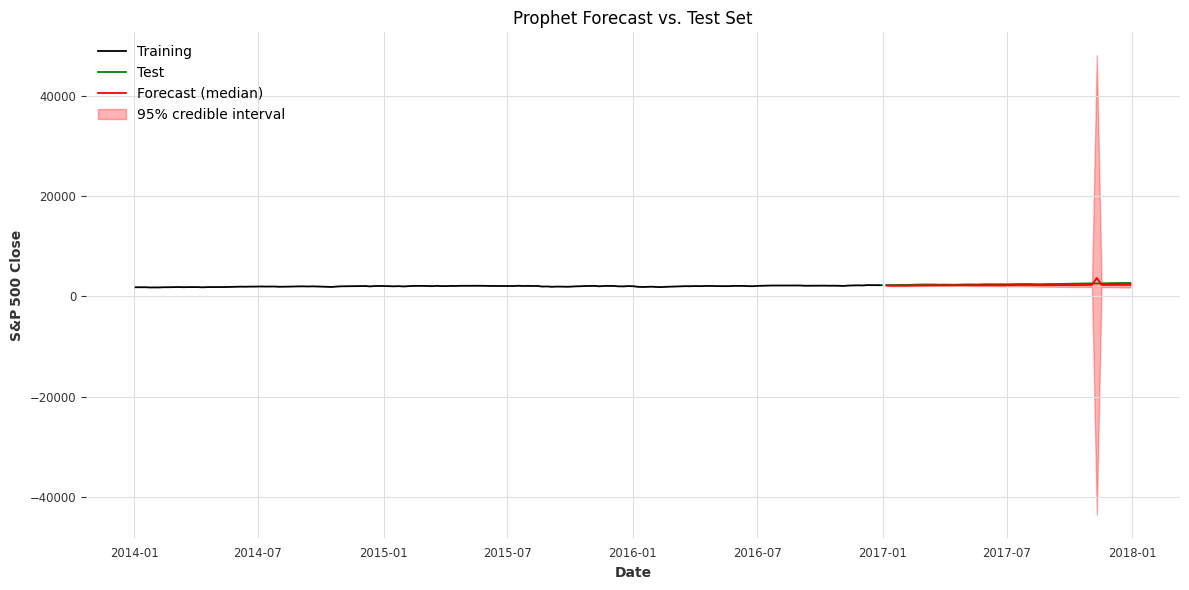

MAPE: 8.98%
MAE:  223.60
RMSE: 264.70


In [11]:
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())

plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")
plt.plot(test_ts.time_index, median_ts.values(), label="Forecast (median)", color="red")

plt.fill_between(
    test_ts.time_index,
    lower_q.ravel(),
    upper_q.ravel(),
    color="red",
    alpha=0.3,
    label="95% credible interval"
)
plt.title("Prophet Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(test_ts, median_ts):.2f}%")
print(f"MAE:  {mae(test_ts, median_ts):.2f}")
print(f"RMSE: {rmse(test_ts, median_ts):.2f}")

### Test on 2023 and 2024

In [59]:
# load data
df = sp500.history(start="2014-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# Fix missing data
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2022) and test (2023-2024)
train_ts_2, test_ts_2 = series.split_before(pd.Timestamp("2023-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_44300\3240597983.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [60]:
model = Prophet(
    country_holidays="US",
    interval_width=0.95,
    changepoint_prior_scale=0.2,   # loosen trend penalty
    random_state=42
)
model.fit(train_ts_2)

20:16:55 - cmdstanpy - INFO - Chain [1] start processing
20:16:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=US, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None, random_state=42, interval_width=0.95, changepoint_prior_scale=0.2)

In [61]:
# forecast the same number of steps as in the test set
h = len(test_ts_2)
Prophet_forecast_2 = model.predict(n=h, num_samples=1000)

In [62]:
samples = Prophet_forecast_2.all_values(copy=False) # shape = (h, 1, 1000)
# squeeze to shape (h, 1000)
samples = samples[:, 0, :]

# Compute quantiles with numpy
lower_q  = np.quantile(samples, 0.025, axis=1)
median_q = np.quantile(samples, 0.50, axis=1)
upper_q  = np.quantile(samples, 0.975, axis=1)

# Reconstruct TimeSeries objects for each quantile
times = Prophet_forecast_2.time_index
lower_ts  = TimeSeries.from_times_and_values(times, lower_q.reshape(-1, 1))
median_ts = TimeSeries.from_times_and_values(times, median_q.reshape(-1, 1))
upper_ts  = TimeSeries.from_times_and_values(times, upper_q.reshape(-1, 1))

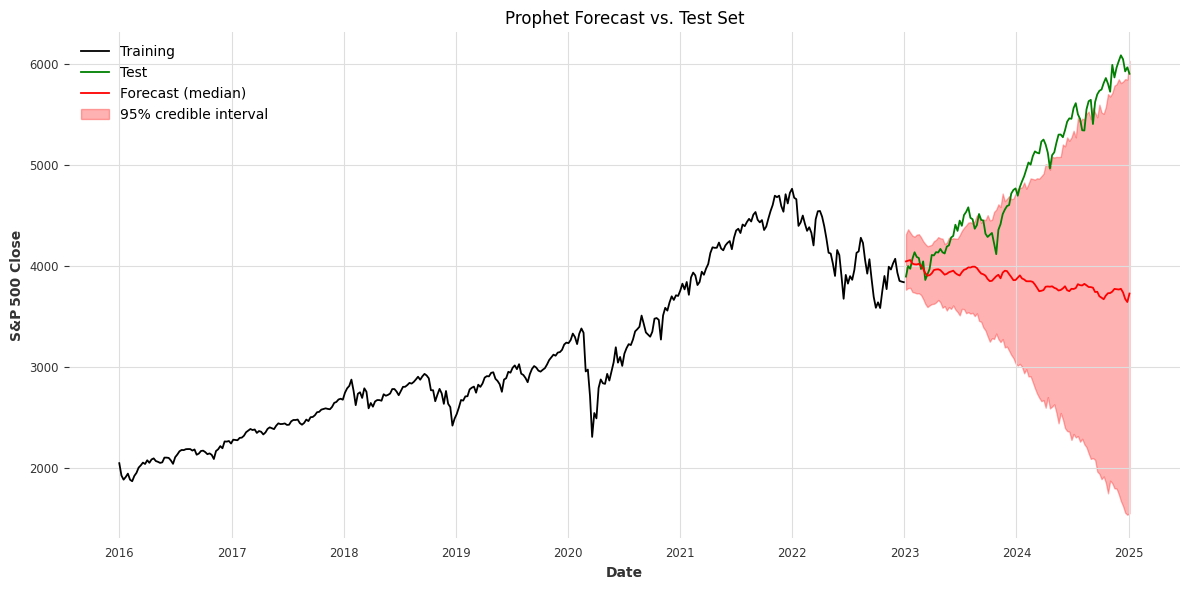

MAPE: 19.30%
MAE:  1019.40
RMSE: 1254.39


In [63]:
train_slice = train_ts_2.slice(pd.Timestamp("2016-01-01"), train_ts_2.end_time())

plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts_2.time_index, test_ts_2.values(), label="Test", color="green")
plt.plot(test_ts_2.time_index, median_ts.values(), label="Forecast (median)", color="red")

plt.fill_between(
    test_ts_2.time_index,
    lower_q.ravel(),
    upper_q.ravel(),
    color="red",
    alpha=0.3,
    label="95% credible interval"
)
plt.title("Prophet Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(test_ts_2, median_ts):.2f}%")
print(f"MAE:  {mae(test_ts_2, median_ts):.2f}")
print(f"RMSE: {rmse(test_ts_2, median_ts):.2f}")

### Backtesting

In [ ]:
df = sp500.history(start="2016-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

# resample to weekly
weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# back test period
backtest_start = pd.Timestamp("2024-01-01")
backtest_end   = pd.Timestamp("2024-12-31")

# fit previos model to new data
model.fit(series[:backtest_start])

C:\Users\USER\AppData\Local\Temp\ipykernel_44300\2325549046.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)
20:17:59 - cmdstanpy - INFO - Chain [1] start processing
20:17:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=US, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None, random_state=42, interval_width=0.95, changepoint_prior_scale=0.2)

In [65]:
prophet_forecast_3 = model.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,    # one step ahead
    stride=1,              # roll forward one step at a time
    retrain=True,          # refit at each step
    last_points_only=True  # keep only the 1-step forecast per date
)

20:18:01 - cmdstanpy - INFO - Chain [1] start processing
20:18:01 - cmdstanpy - INFO - Chain [1] done processing
20:18:02 - cmdstanpy - INFO - Chain [1] start processing
20:18:02 - cmdstanpy - INFO - Chain [1] done processing
20:18:02 - cmdstanpy - INFO - Chain [1] start processing
20:18:02 - cmdstanpy - INFO - Chain [1] done processing
20:18:02 - cmdstanpy - INFO - Chain [1] start processing
20:18:02 - cmdstanpy - INFO - Chain [1] done processing
20:18:02 - cmdstanpy - INFO - Chain [1] start processing
20:18:02 - cmdstanpy - INFO - Chain [1] done processing
20:18:02 - cmdstanpy - INFO - Chain [1] start processing
20:18:03 - cmdstanpy - INFO - Chain [1] done processing
20:18:03 - cmdstanpy - INFO - Chain [1] start processing
20:18:03 - cmdstanpy - INFO - Chain [1] done processing
20:18:03 - cmdstanpy - INFO - Chain [1] start processing
20:18:03 - cmdstanpy - INFO - Chain [1] done processing
20:18:03 - cmdstanpy - INFO - Chain [1] start processing
20:18:03 - cmdstanpy - INFO - Chain [1]

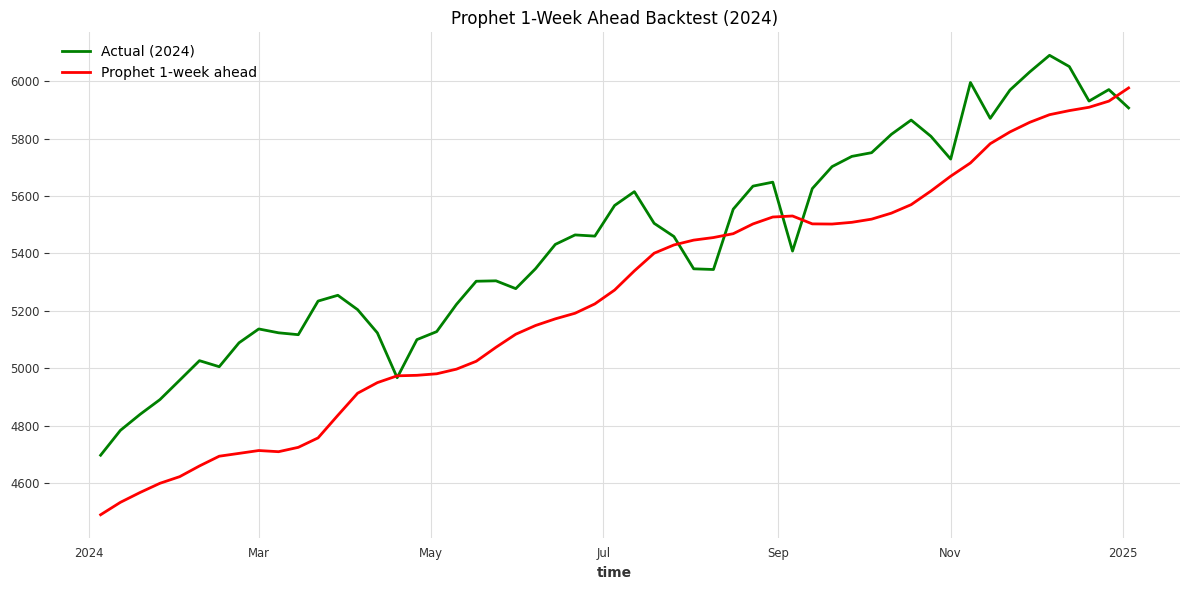

MAPE: 3.99%
MAE:  213.40
RMSE: 241.34


In [66]:
# Slice out the actuals over the same 2024 period
actuals_bt = series[backtest_start:backtest_end]

# Plot actual vs. 1-step Prophet backtest
plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2024)", color="green")
prophet_forecast_3.plot(label="Prophet 1-week ahead", color="red")
plt.title("Prophet 1-Week Ahead Backtest (2024)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate accuracy
print(f"MAPE: {mape(actuals_bt, prophet_forecast_3):.2f}%")
print(f"MAE:  {mae(actuals_bt, prophet_forecast_3):.2f}")
print(f"RMSE: {rmse(actuals_bt, prophet_forecast_3):.2f}")